## Data Mining Project: Airbnb

In [3]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


## Import Required Packages and libraries

In [4]:
import numpy as np 
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt

import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

import dmba

%matplotlib inline
!pip install folium
import folium


## Load the dataset

In [6]:
df = pd.read_csv('airbnb.csv')
df.head() 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2/19/23,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,8/6/17,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,10/27/22,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,6/28/19,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,110,1,770,2/25/23,4.65,2,159,34,San Francisco


## Dataset pre-processing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              232147 non-null  int64  
 1   name                            232131 non-null  object 
 2   host_id                         232147 non-null  int64  
 3   host_name                       232134 non-null  object 
 4   neighbourhood_group             96500 non-null   object 
 5   neighbourhood                   232147 non-null  object 
 6   latitude                        232147 non-null  float64
 7   longitude                       232147 non-null  float64
 8   room_type                       232147 non-null  object 
 9   price                           232147 non-null  int64  
 10  minimum_nights                  232147 non-null  int64  
 11  number_of_reviews               232147 non-null  int64  
 12  last_review     

## 1. Missing Value Treatment

In [8]:
#Checking Missing values
pd.DataFrame(df).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64

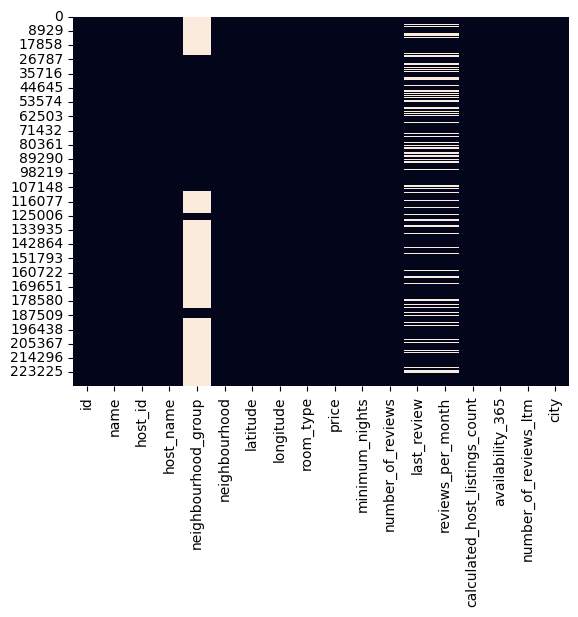

In [9]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)
plt.show()

## Dropping columns with high NA and ID column

In [10]:
df.drop(columns=['id','last_review', 'reviews_per_month', 'neighbourhood_group'], inplace=True)


In [11]:
summary_stats = np.round(df.describe(), decimals=4)
print(summary_stats)

            host_id     latitude    longitude        price  minimum_nights  \
count  2.321470e+05  232147.0000  232147.0000  232147.0000     232147.0000   
mean   1.582248e+08      36.6106     -98.3014     259.4680         13.4959   
std    1.587164e+08       5.1265      19.7069    1024.6459         27.9206   
min    2.300000e+01      25.9573    -123.0891       0.0000          1.0000   
25%    2.299242e+07      33.9762    -118.3151      91.0000          2.0000   
50%    1.005783e+08      36.1906     -97.7277     149.0000          3.0000   
75%    2.686930e+08      40.7174     -77.0262     250.0000         30.0000   
max    5.069384e+08      47.7340     -70.9960  100000.0000       1250.0000   

       number_of_reviews  calculated_host_listings_count  availability_365  \
count        232147.0000                     232147.0000       232147.0000   
mean             40.9152                         29.8791          180.9857   
std              80.6492                        106.0137       

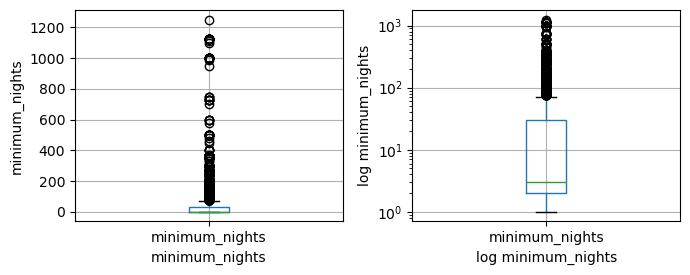

In [12]:
#price boxplot- detecting outliers
#converting boxplot from normal to log scale
#change subplots rows and columns as required
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# regular scale
ax = df.boxplot(column='minimum_nights', ax=axes[0])
ax.set_xlabel('minimum_nights')
ax.set_ylabel('minimum_nights')

# log scale
ax = df.boxplot(column='minimum_nights', ax=axes[1])
ax.set_xlabel('log minimum_nights')
ax.set_ylabel('log minimum_nights')
ax.set_yscale('log')

# suppress the title
axes[0].get_figure().suptitle('')
plt.tight_layout()

plt.show()

## 2. Removing Outliers for Price Variable

In [13]:
lower_bound = .05
upper_bound = .97
airbnb_df = df[df['price'].between(df['price'].quantile(lower_bound), df['price'].quantile(upper_bound))]

In [14]:
summary_stats = np.round(airbnb_df.describe(), decimals=4)
print(summary_stats)

            host_id     latitude    longitude        price  minimum_nights  \
count  2.135910e+05  213591.0000  213591.0000  213591.0000     213591.0000   
mean   1.578365e+08      36.5884     -98.3491     196.9707         13.0995   
std    1.585902e+08       5.1586      19.7081     148.4660         26.9127   
min    2.300000e+01      25.9573    -123.0891      46.0000          1.0000   
25%    2.308585e+07      33.9612    -118.3216      98.0000          2.0000   
50%    1.003077e+08      36.1900     -97.7280     150.0000          3.0000   
75%    2.683223e+08      40.7170     -77.0358     245.0000         30.0000   
max    5.069384e+08      47.7340     -70.9960     903.0000       1250.0000   

       number_of_reviews  calculated_host_listings_count  availability_365  \
count        213591.0000                     213591.0000       213591.0000   
mean             42.7009                         29.4082          181.8433   
std              82.3335                        107.9053       

In [15]:
row_count = airbnb_df.shape[0]
print("The number of rows in the DataFrame is:", row_count)

The number of rows in the DataFrame is: 213591


## Exploratory Data Analysis

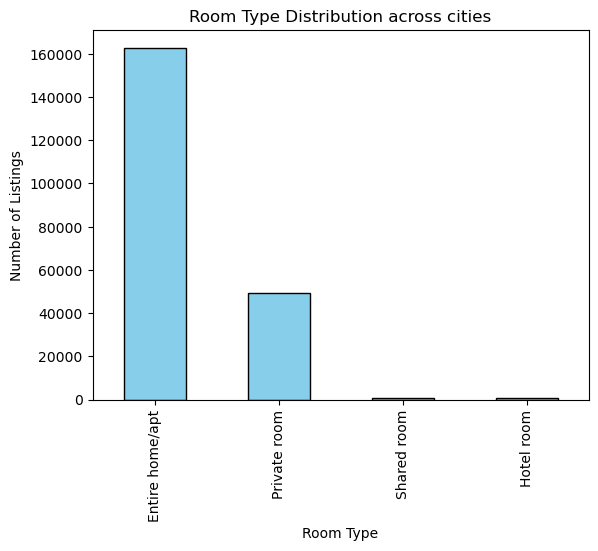

In [16]:
# Bar chart for room_type distribution across cities
room_type_counts = airbnb_df['room_type'].value_counts()
room_type_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.title('Room Type Distribution across cities')

# Show the plot
plt.show()

In [17]:
# Room_type and median prices
airbnb_df.groupby('room_type')['price'].median()

room_type
Entire home/apt    174.0
Hotel room         197.0
Private room        85.0
Shared room         75.0
Name: price, dtype: float64

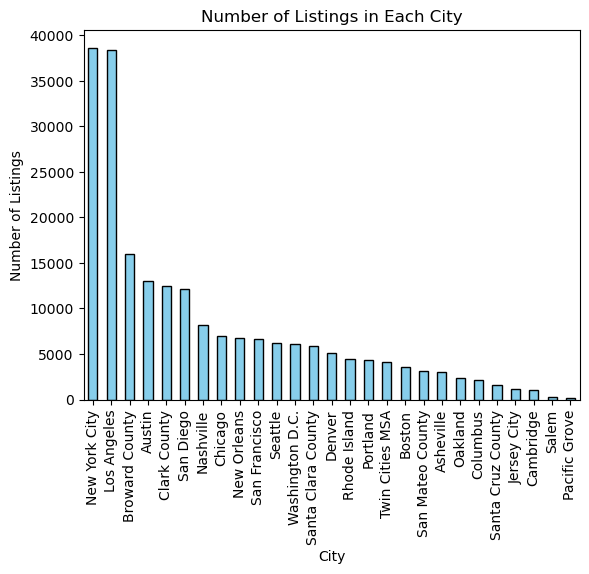

In [18]:
# Bar chart for number of listings in each city
city_counts = airbnb_df['city'].value_counts()

# Plotting the bar chart
city_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.title('Number of Listings in Each City')

# Show the plot
plt.show()

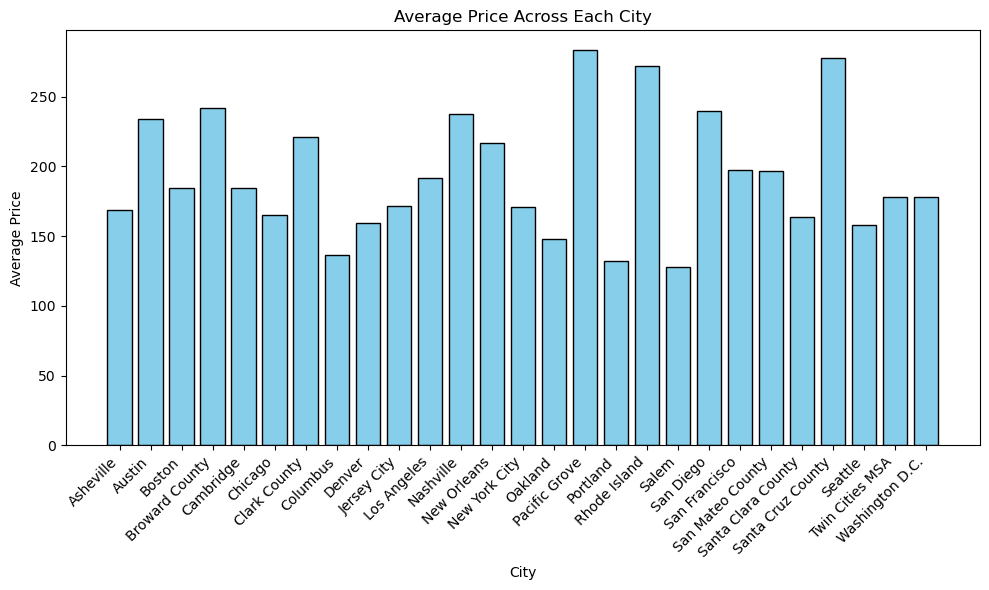

In [19]:
# Bar chart for average price across each city
average_price_by_city = airbnb_df.groupby('city')['price'].mean().reset_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(average_price_by_city['city'], average_price_by_city['price'], color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Average Price Across Each City')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

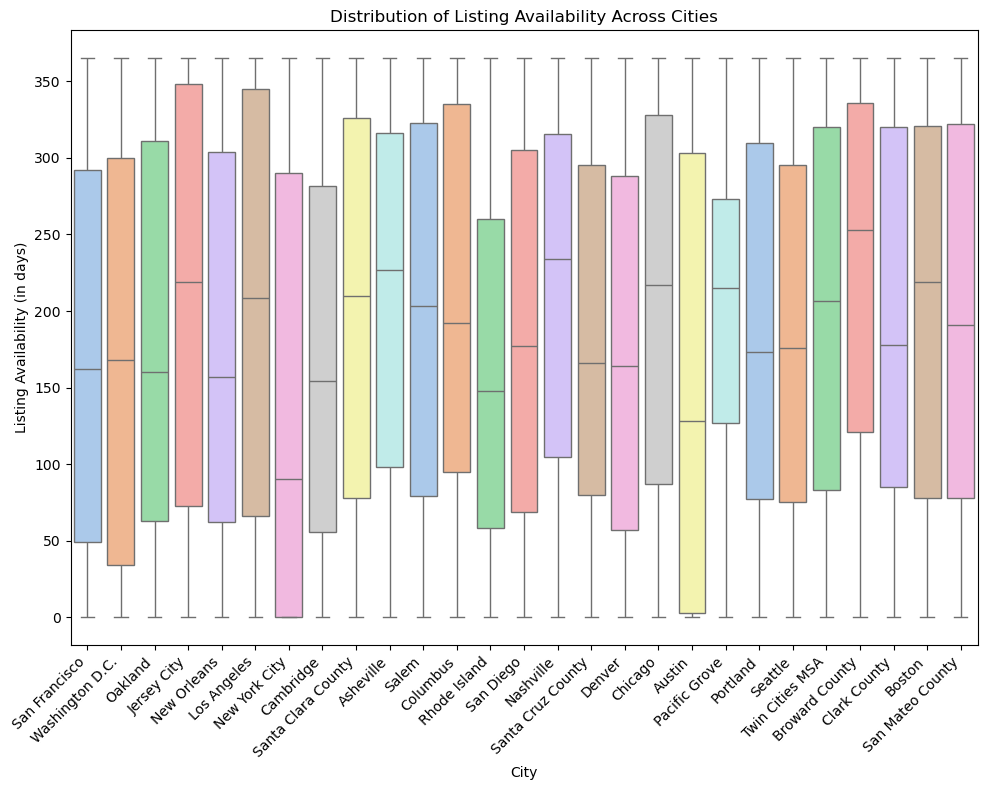

In [20]:
# Boxplot for distribution of listing availability across cities
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.boxplot(x='city', y='availability_365', data=airbnb_df, palette='pastel')

# Adding labels and title
plt.xlabel('City')
plt.ylabel('Listing Availability (in days)')
plt.title('Distribution of Listing Availability Across Cities')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

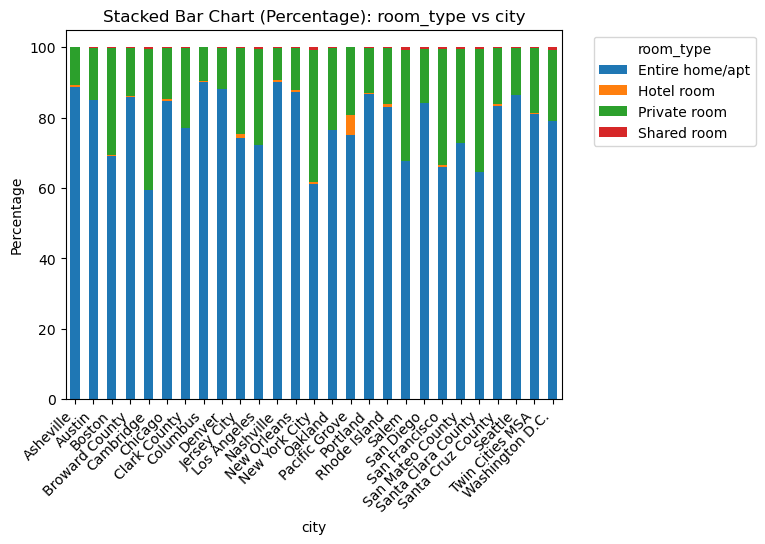

In [21]:
# Stacked Bar chart for room_type vs city
x_variable = 'city'
y_variable = 'room_type'

# Create a pivot table for the stacked bar chart
pivot_data = airbnb_df.pivot_table(index=x_variable, columns=y_variable, aggfunc='size', fill_value=0)

# Normalize the values to percentages
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting a stacked bar chart with default colors
plt.figure(figsize=(12, 6))
pivot_data_percentage.plot(kind='bar', stacked=True)
plt.title(f'Stacked Bar Chart (Percentage): {y_variable} vs {x_variable}')
plt.xlabel(x_variable)
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title=y_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

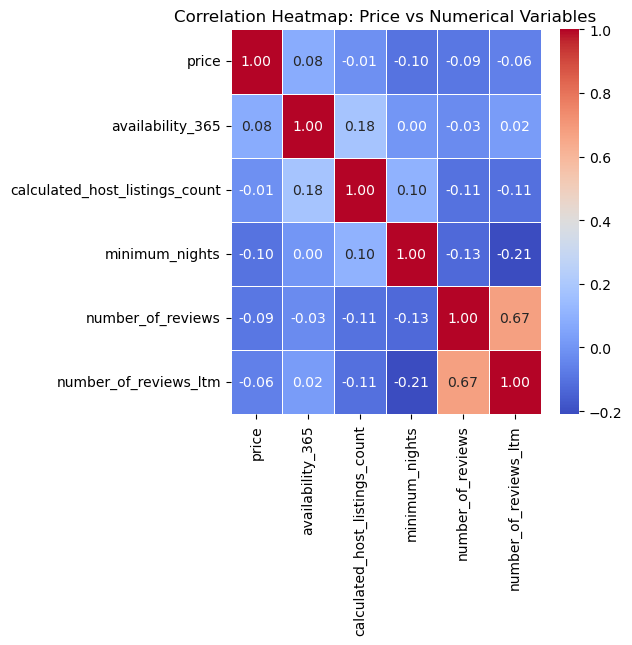

In [22]:
# Heatmap for price vs numerical variables
selected_columns = ['price', 'availability_365', 'calculated_host_listings_count', 'minimum_nights', 'number_of_reviews', 'number_of_reviews_ltm']
selected_data = airbnb_df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(5, 5))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Heatmap: Price vs Numerical Variables')

# Show the plot
plt.show()

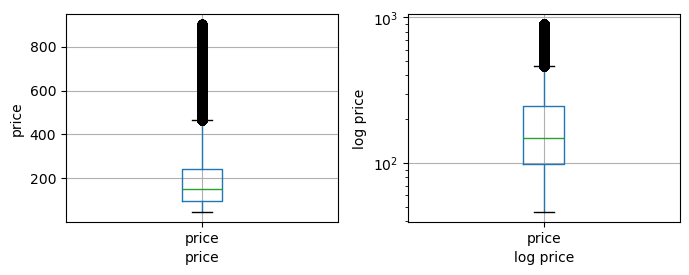

In [23]:
#price outliers- after dara pre-processing
#converting boxplot from normal to log scale
#change subplots rows and columns as required
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# regular scale
ax = airbnb_df.boxplot(column='price', ax=axes[0])
ax.set_xlabel('price')
ax.set_ylabel('price')

# log scale
ax = airbnb_df.boxplot(column='price', ax=axes[1])
ax.set_xlabel('log price')
ax.set_ylabel('log price')
ax.set_yscale('log')

# suppress the title
axes[0].get_figure().suptitle('')
plt.tight_layout()

plt.show()

In [24]:
MapModel = airbnb_df[['latitude', 'longitude']]
model = KMeans()
kmeans = KMeans(n_clusters = 15, random_state=42,n_init=10).fit(MapModel)
kmeans.cluster_centers_
cluster_map = folium.Map([41.8781, -87.6298], zoom_start=4)
for i in range(kmeans.cluster_centers_.shape[0]):
    num = sum(kmeans.labels_ == i)
    folium.CircleMarker([kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1]],
                        radius=15,
                        popup=str(num) + ' Listings Associated with this Cluster',
                        fill_color="#3db7e4",
                        ).add_to(cluster_map)
cluster_map

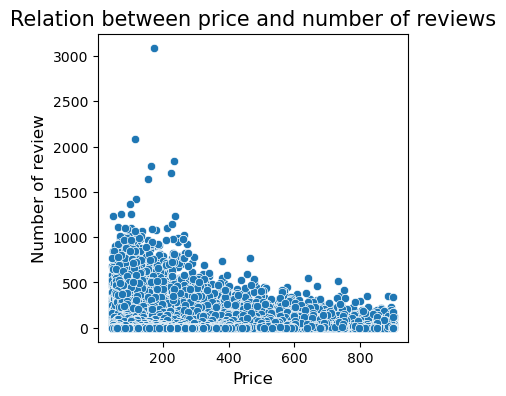

In [31]:
### Price and reviews:
plt.figure(figsize=(4,4))
sns.scatterplot(x='price',y='number_of_reviews',data=airbnb_df)
plt.title("Relation between price and number of reviews",fontsize=15)
plt.xlabel("Price",fontsize=12)
plt.ylabel("Number of review",fontsize=12)
plt.show()



In [32]:
### Mean and minimum review counts across different cities
multi_host=airbnb_df[airbnb_df.calculated_host_listings_count>1]
multi_host['review_min']=multi_host.groupby('host_id')['number_of_reviews'].min()
multi_host['review_mean'] = multi_host.groupby('host_id')['number_of_reviews'].mean()



In [33]:
def _gen_histogram(airbnb_df,column):
    plt.figure(figsize=(4,4))
    sns.distplot(airbnb_df[column].dropna(),bins=10)
    plt.xlabel(r"{}".format(column))
    plt.ylabel("Density")
    plt.title(r"Distribution of {}".format(column))

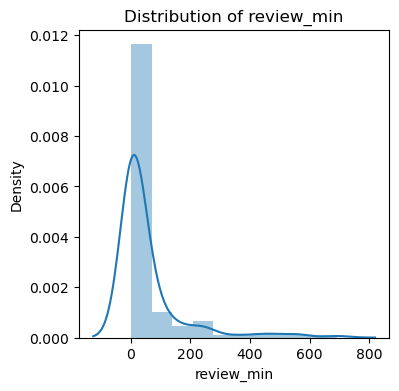

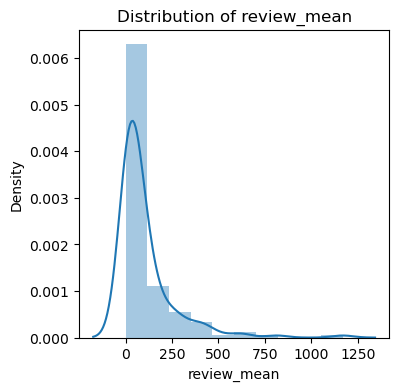

In [34]:
columns=['review_min','review_mean']

for c in columns:
    _gen_histogram(multi_host,c)

## Model 1: Price prediction 

## Creating Dummies for Categorical variables - Room_Type, City

In [35]:
airbnb_df = pd.get_dummies(airbnb_df, columns=['room_type','city'], prefix=['room_type','city'], drop_first=True) 

In [36]:
airbnb_df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'city_Austin',
       'city_Boston', 'city_Broward County', 'city_Cambridge', 'city_Chicago',
       'city_Clark County', 'city_Columbus', 'city_Denver', 'city_Jersey City',
       'city_Los Angeles', 'city_Nashville', 'city_New Orleans',
       'city_New York City', 'city_Oakland', 'city_Pacific Grove',
       'city_Portland', 'city_Rhode Island', 'city_Salem', 'city_San Diego',
       'city_San Francisco', 'city_San Mateo County',
       'city_Santa Clara County', 'city_Santa Cruz County', 'city_Seattle',
       'city_Twin Cities MSA', 'city_Washington D.C.'],
      dtype='object')

## Multiple Linear Regression for Price Prediction - Base Model

In [37]:
predictors = ['minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'city_Austin',
       'city_Boston', 'city_Broward County', 'city_Cambridge', 'city_Chicago',
       'city_Clark County', 'city_Columbus', 'city_Denver', 'city_Jersey City',
       'city_Los Angeles', 'city_Nashville', 'city_New Orleans',
       'city_New York City', 'city_Oakland', 'city_Pacific Grove',
       'city_Portland', 'city_Rhode Island', 'city_Salem', 'city_San Diego',
       'city_San Francisco', 'city_San Mateo County',
       'city_Santa Clara County', 'city_Santa Cruz County', 'city_Seattle',
       'city_Twin Cities MSA', 'city_Washington D.C.']

outcome = 'price'

# partition data
X = airbnb_df[predictors]
y = airbnb_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()
air_lm = LinearRegression()
air_lm.fit(train_X, train_y)


LinearRegression()

## Measuring the performance on Validation Set

In [38]:
# Use predict() to make predictions on a new set
air_lm_pred = air_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': air_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - air_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, air_lm_pred)

         Predicted  Actual    Residual
114669   99.414879     100    0.585121
59321   232.740770      80 -152.740770
129629  282.746130      85 -197.746130
15407   177.184582     256   78.815418
132314  250.465667     574  323.534333
22171   254.852827     155  -99.852827
11568   223.188864     110 -113.188864
216838  268.601394     280   11.398606
117266  166.067391     136  -30.067391
19411   234.441949     174  -60.441949
82937   197.509568     150  -47.509568
149846  310.137595     192 -118.137595
151627   59.695642      49  -10.695642
201591  268.674228     280   11.325772
195094  278.188810     121 -157.188810
47990   244.816364     187  -57.816364
172508  248.295614     164  -84.295614
184335  162.268201      68  -94.268201
4809    143.916540      89  -54.916540
85698   139.989828     295  155.010172

Regression statistics

                      Mean Error (ME) : -1.4085
       Root Mean Squared Error (RMSE) : 137.0741
            Mean Absolute Error (MAE) : 95.2195
          Me

## Random Forest

In [39]:
rf_df = pd.read_csv('airbnb.csv', header = 0)

In [40]:
rf_df.drop(columns=['id','last_review', 'reviews_per_month', 'neighbourhood_group'], inplace=True)

In [41]:
# Removing Outliers for Price
lower_bound = .05
upper_bound = .97
rf1_df = df[rf_df['price'].between(df['price'].quantile(lower_bound), rf_df['price'].quantile(upper_bound))]

In [42]:
rf1_df = pd.get_dummies(rf1_df, columns=['room_type','city'], prefix=['room_type','city'], drop_first=False)
rf1_df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'city_Asheville', 'city_Austin', 'city_Boston',
       'city_Broward County', 'city_Cambridge', 'city_Chicago',
       'city_Clark County', 'city_Columbus', 'city_Denver', 'city_Jersey City',
       'city_Los Angeles', 'city_Nashville', 'city_New Orleans',
       'city_New York City', 'city_Oakland', 'city_Pacific Grove',
       'city_Portland', 'city_Rhode Island', 'city_Salem', 'city_San Diego',
       'city_San Francisco', 'city_San Mateo County',
       'city_Santa Clara County', 'city_Santa Cruz County', 'city_Seattle',
       'city_Twin Cities MSA', 'city_Washington D.C.'],
      dtype='object')

In [43]:
predictors = ['minimum_nights','number_of_reviews','calculated_host_listings_count',
             'availability_365','number_of_reviews_ltm', 'room_type_Entire home/apt',
             'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'city_Asheville', 'city_Austin', 'city_Boston',
       'city_Broward County', 'city_Cambridge', 'city_Chicago',
       'city_Clark County', 'city_Columbus', 'city_Denver', 'city_Jersey City',
       'city_Los Angeles', 'city_Nashville', 'city_New Orleans',
       'city_New York City', 'city_Oakland', 'city_Pacific Grove',
       'city_Portland', 'city_Rhode Island', 'city_Salem', 'city_San Diego',
       'city_San Francisco', 'city_San Mateo County',
       'city_Santa Clara County', 'city_Santa Cruz County', 'city_Seattle',
       'city_Twin Cities MSA', 'city_Washington D.C.']
outcome = 'price'

# partition data
A = rf1_df[predictors]
b = rf1_df[outcome]
train_A, valid_a, train_b, valid_b = train_test_split(A, b, test_size=0.4, random_state=1)

In [44]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(train_A, train_b)

RandomForestRegressor(n_estimators=50, random_state=1)

## Variable Importance Plot - To understand the importance of city 

                           feature  importance       std
27                      city_Salem    0.000315  0.000141
8            room_type_Shared room    0.000631  0.000229
7           room_type_Private room    0.000717  0.000289
18                city_Jersey City    0.001192  0.000217
6             room_type_Hotel room    0.001355  0.000377
13                  city_Cambridge    0.001379  0.000232
24              city_Pacific Grove    0.001580  0.000243
23                    city_Oakland    0.002219  0.000346
9                   city_Asheville    0.002505  0.000340
16                   city_Columbus    0.002605  0.000312
11                     city_Boston    0.003389  0.000429
17                     city_Denver    0.003939  0.000431
33                    city_Seattle    0.003940  0.000383
30           city_San Mateo County    0.004042  0.000421
32          city_Santa Cruz County    0.004773  0.000403
34            city_Twin Cities MSA    0.004922  0.000584
31         city_Santa Clara Cou

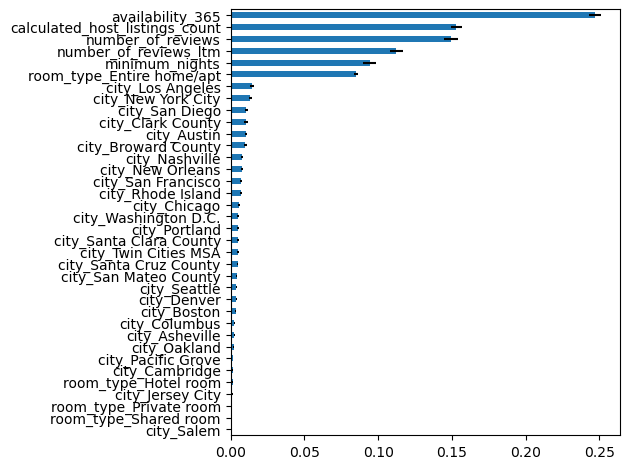

In [45]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

variables_df = pd.DataFrame({'feature': train_A.columns, 'importance': importances, 'std': std})
variables_df = variables_df.sort_values('importance')
print(variables_df)
variables_df.to_csv('variables_list.csv', index=True)

ax = variables_df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Exhaustive Search
Running Exhaustive serach for variables other than city

In [ ]:
#We will first define a couple of functions to be used in Exhaustive Search function
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
    
# Define the width of output presentation to be wider to display results in two rows (instead of more rows otherwise). 
pd.set_option('display.width', 100)

# Display the Exhaustive Search results.
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
#print(pd.DataFrame(data)) #Good enough too. Variables appear in the same order in dataset 

# Reset the output width to the default. 
pd.reset_option('display.width')

## Backward elimination

In [46]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

bestBE_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365, number_of_reviews_ltm, room_type_Hotel room, room_type_Private room, room_type_Shared room, city_Austin, city_Boston, city_Broward County, city_Cambridge, city_Chicago, city_Clark County, city_Columbus, city_Denver, city_Jersey City, city_Los Angeles, city_Nashville, city_New Orleans, city_New York City, city_Oakland, city_Pacific Grove, city_Portland, city_Rhode Island, city_Salem, city_San Diego, city_San Francisco, city_San Mateo County, city_Santa Clara County, city_Santa Cruz County, city_Seattle, city_Twin Cities MSA, city_Washington D.C.
Start: score=1625392.32
Step: score=1625390.56, remove room_type_Hotel room
Step: score=1625390.56, remove None
['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'room_type_Private room', 'room_type_Shared room', 'city_Austin', 'city_Boston', 'city_Broward County', 'city_Cambridge', 

## Final Model using best predictor variables

In [47]:
#predictors = ['availability_365','calculated_host_listings_count','minimum_nights','number_of_reviews',
#              'room_type_Private room', 'room_type_Shared room'] #n=6, RMSE-139.9665

predictors = ['availability_365','calculated_host_listings_count','minimum_nights','number_of_reviews','room_type_Private room'] #n=5, RMSE-140.1425

outcome = 'price'

# partition data
X = airbnb_df[predictors]
y = airbnb_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
air_lm = LinearRegression()
air_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', air_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': air_lm.coef_}))

intercept  222.05698928637926
                        Predictor  coefficient
0                availability_365     0.081966
1  calculated_host_listings_count    -0.013736
2                  minimum_nights    -0.566628
3               number_of_reviews    -0.208780
4          room_type_Private room   -98.681998


In [48]:
# Use predict() to make predictions on a new set
air_lm_pred = air_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': air_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - air_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, air_lm_pred)

         Predicted  Actual    Residual
114669  122.794628     100  -22.794628
59321   232.633933      80 -152.633933
129629  246.586786      85 -161.586786
15407   230.975362     256   25.024638
132314  221.182368     574  352.817632
22171   245.348278     155  -90.348278
11568   234.395250     110 -124.395250
216838  246.622213     280   33.377787
117266  179.697515     136  -43.697515
19411   221.141332     174  -47.141332
82937   204.835633     150  -54.835633
149846  228.313863     192  -36.313863
151627  101.337949      49  -52.337949
201591  239.386293     280   40.613707
195094  249.884633     121 -128.884633
47990   246.416965     187  -59.416965
172508  226.637902     164  -62.637902
184335  195.833327      68 -127.833327
4809    135.921238      89  -46.921238
85698   147.664712     295  147.335288

Regression statistics

                      Mean Error (ME) : -1.3252
       Root Mean Squared Error (RMSE) : 140.1425
            Mean Absolute Error (MAE) : 98.2624
          Me

## Plotting the residuals

0.9520699462762036


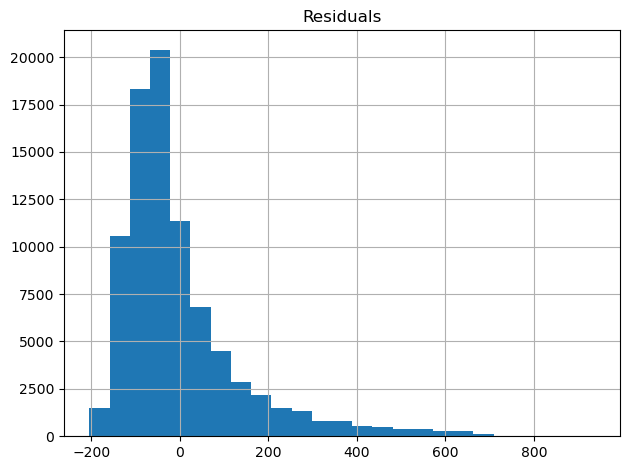

In [49]:
air_lm_pred = air_lm.predict(valid_X)
all_residuals = valid_y - air_lm_pred

# Determine the percentage of datapoints with a residual in [-300, 300] = approx. 95\%
print(len(all_residuals[(all_residuals > -300) & (all_residuals < 300)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## Model 2: Predict the room type

In [67]:
airbnb_df = pd.read_csv("airbnb.csv")

In [68]:
airbnb_df = airbnb_df.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'last_review' ])
airbnb_df = airbnb_df.dropna()
airbnb_df.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,Entire home/apt,202,2,383,2.31,1,128,59,San Francisco
1,Entire home/apt,235,30,111,0.66,1,365,0,San Francisco
2,Private room,56,32,9,0.09,13,365,1,San Francisco
3,Entire home/apt,575,9,28,0.17,2,365,0,San Francisco
4,Private room,110,1,770,4.65,2,159,34,San Francisco


In [69]:
airbnb_df.city = airbnb_df.city.astype('category')
airbnb_df = pd.get_dummies(airbnb_df, columns=['city'], drop_first=False, dtype = int)

In [70]:
# Removing Outliers
lower_bound = .05
upper_bound = .97
airbnb_df = airbnb_df[airbnb_df['price'].between(airbnb_df['price'].quantile(lower_bound), airbnb_df['price'].quantile(upper_bound))]

## Classification tree for room_type

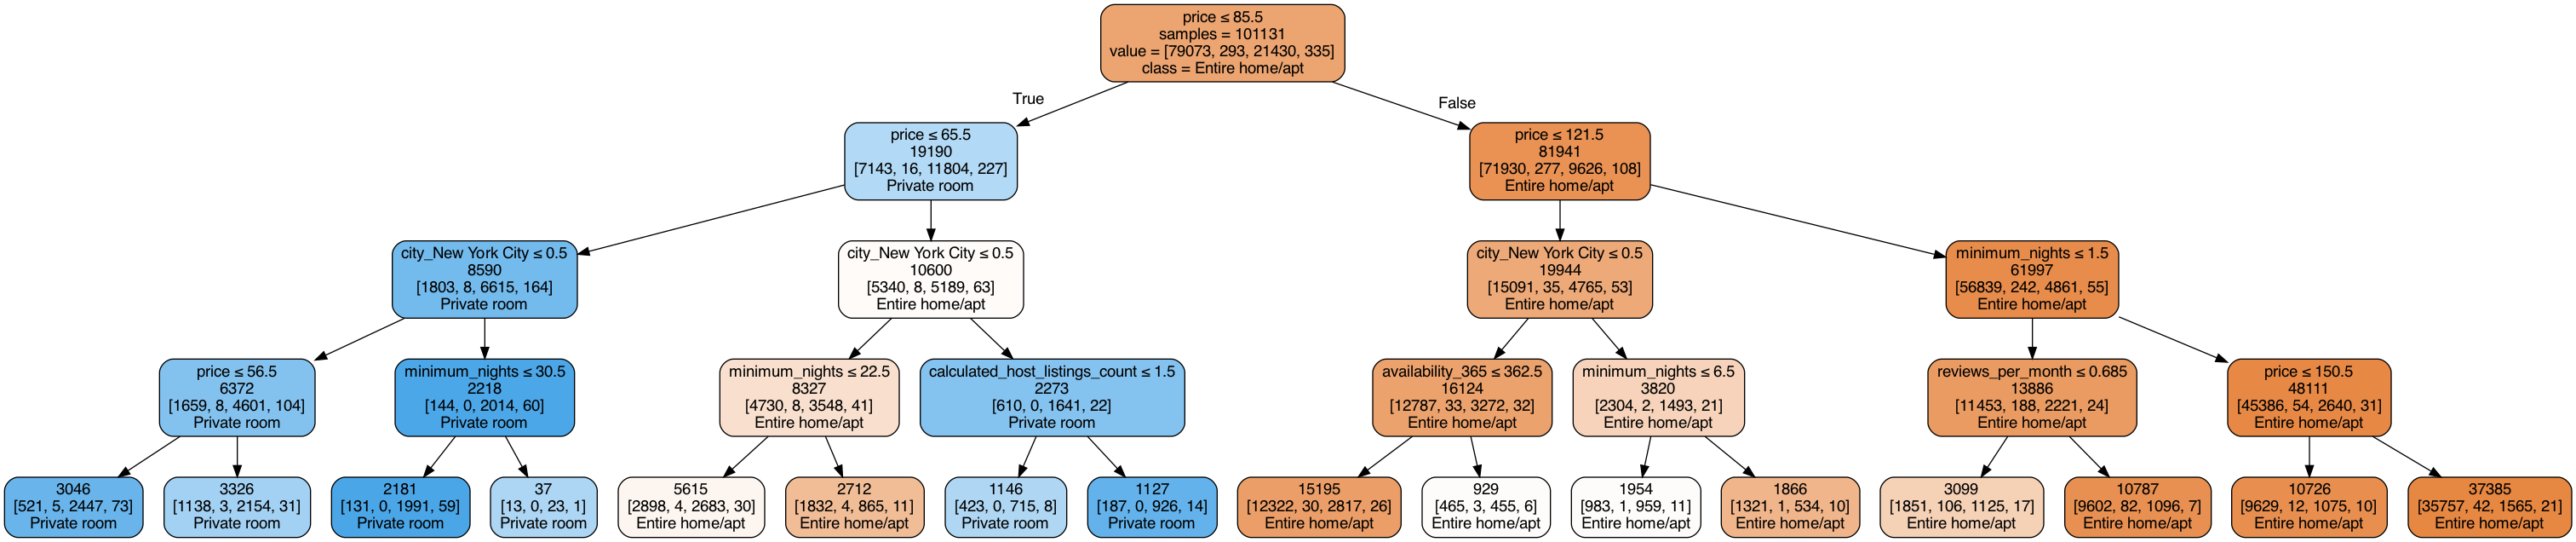

In [71]:
#base model
X = airbnb_df[['price', 'minimum_nights', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews',
       'reviews_per_month', 'city_Asheville', 
               'city_Austin', 'city_Boston', 'city_Broward County', 'city_Cambridge', 'city_Chicago', 'city_Clark County', 
               'city_Columbus', 'city_Denver', 'city_Jersey City', 'city_Los Angeles', 'city_Nashville','city_New Orleans', 
               'city_New York City', 'city_Oakland', 'city_Pacific Grove', 'city_Portland', 'city_Rhode Island',
               'city_Salem', 'city_San Diego', 'city_San Francisco','city_San Mateo County', 'city_Santa Clara County',
               'city_Santa Cruz County', 'city_Seattle', 'city_Twin Cities MSA', 'city_Washington D.C.']]
y = airbnb_df['room_type']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier(random_state=1, max_depth=4)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns, class_names=fullClassTree.classes_)

In [72]:
# 0: entire apt, 1: hotel room, 2: personal room, 3: shared room
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8391)

       Prediction
Actual     0     1     2     3
     0 51001     0  1570     0
     1   214     0    12     0
     2  8808     0  5571     0
     3   101     0   144     0


In [73]:
tree_nodes = fullClassTree.tree_.node_count
print('Number of nodes:', tree_nodes)

Number of nodes: 31


In [74]:
# Five-fold cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.831', '0.825', '0.830', '0.827', '0.829']
Accuracy: 0.829 (+/- 0.004)
Accuracy: 0.829 (+/- 0.002)


                           feature  importance       std
24                      city_Salem    0.000248  0.000102
21              city_Pacific Grove    0.000582  0.000190
15                city_Jersey City    0.001194  0.000265
29          city_Santa Cruz County    0.001825  0.000362
20                    city_Oakland    0.002070  0.000383
13                   city_Columbus    0.002493  0.000712
6                   city_Asheville    0.002512  0.000532
23               city_Rhode Island    0.002862  0.000566
10                  city_Cambridge    0.002878  0.000605
30                    city_Seattle    0.002961  0.000671
27           city_San Mateo County    0.002981  0.000574
31            city_Twin Cities MSA    0.003035  0.000509
17                  city_Nashville    0.003517  0.000776
14                     city_Denver    0.003535  0.000973
8                      city_Boston    0.003564  0.000725
32            city_Washington D.C.    0.003675  0.000654
18                city_New Orle

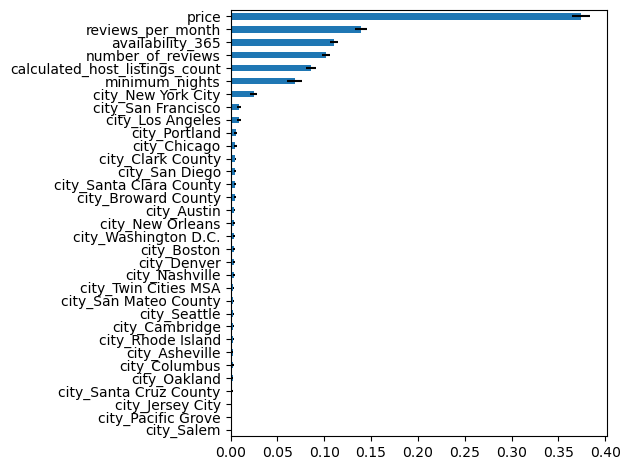

In [75]:
#random forest
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

rdf = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
rdf = rdf.sort_values('importance')
print(rdf)

ax = rdf.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [76]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.8852)

       Prediction
Actual     0     1     2     3
     0 50352     2  2212     5
     1   102    63    61     0
     2  5139     5  9229     6
     3    68     0   141    36


In [77]:
airbnb_df.columns

Index(['room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'city_Asheville',
       'city_Austin', 'city_Boston', 'city_Broward County', 'city_Cambridge',
       'city_Chicago', 'city_Clark County', 'city_Columbus', 'city_Denver',
       'city_Jersey City', 'city_Los Angeles', 'city_Nashville',
       'city_New Orleans', 'city_New York City', 'city_Oakland',
       'city_Pacific Grove', 'city_Portland', 'city_Rhode Island',
       'city_Salem', 'city_San Diego', 'city_San Francisco',
       'city_San Mateo County', 'city_Santa Clara County',
       'city_Santa Cruz County', 'city_Seattle', 'city_Twin Cities MSA',
       'city_Washington D.C.'],
      dtype='object')

In [78]:
airbnb_df['other_cities'] = (airbnb_df['city_Austin'] + airbnb_df['city_Asheville'] + airbnb_df['city_Boston'] 
+ airbnb_df['city_Broward County'] +  airbnb_df['city_Cambridge'] + airbnb_df['city_Chicago'] 
+ airbnb_df['city_Clark County'] + airbnb_df['city_Columbus'] + airbnb_df['city_Denver'] + airbnb_df['city_Jersey City'] 
+ airbnb_df['city_Nashville'] + airbnb_df['city_New Orleans'] +  airbnb_df['city_Oakland'] + airbnb_df['city_Pacific Grove'] 
+ airbnb_df['city_Portland'] + airbnb_df['city_Rhode Island'] + airbnb_df['city_Salem'] + airbnb_df['city_San Diego'] 
+ airbnb_df['city_San Mateo County'] + airbnb_df['city_Santa Clara County'] +  airbnb_df['city_Santa Cruz County'] 
+ airbnb_df['city_Seattle'] + airbnb_df['city_Twin Cities MSA'] + airbnb_df['city_Washington D.C.']
+ airbnb_df['city_San Francisco'] + airbnb_df['city_Los Angeles'])


In [79]:
airbnb_df = airbnb_df.drop(columns = ['city_Asheville', 'city_Austin', 'city_Boston', 'city_Broward County', 'city_Cambridge',
       'city_Chicago', 'city_Clark County', 'city_Columbus', 'city_Denver', 'city_Jersey City', 'city_Nashville','city_New Orleans', 'city_Oakland',
       'city_Pacific Grove', 'city_Portland', 'city_Rhode Island','city_Salem', 'city_San Diego','city_San Mateo County', 'city_Santa Clara County',
       'city_Santa Cruz County', 'city_Seattle', 'city_Twin Cities MSA','city_Washington D.C.', 'city_Los Angeles', 'city_San Francisco' ])
airbnb_df.head(10)

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city_New York City,other_cities
0,Entire home/apt,202,2,383,2.31,1,128,59,0,1
1,Entire home/apt,235,30,111,0.66,1,365,0,0,1
2,Private room,56,32,9,0.09,13,365,1,0,1
3,Entire home/apt,575,9,28,0.17,2,365,0,0,1
4,Private room,110,1,770,4.65,2,159,34,0,1
5,Private room,95,1,19,0.12,2,365,1,0,1
6,Entire home/apt,259,5,234,1.69,1,32,13,0,1
7,Private room,100,30,80,0.74,1,331,1,0,1
8,Entire home/apt,79,30,18,0.13,1,230,0,0,1
9,Private room,65,32,7,0.05,13,365,1,0,1


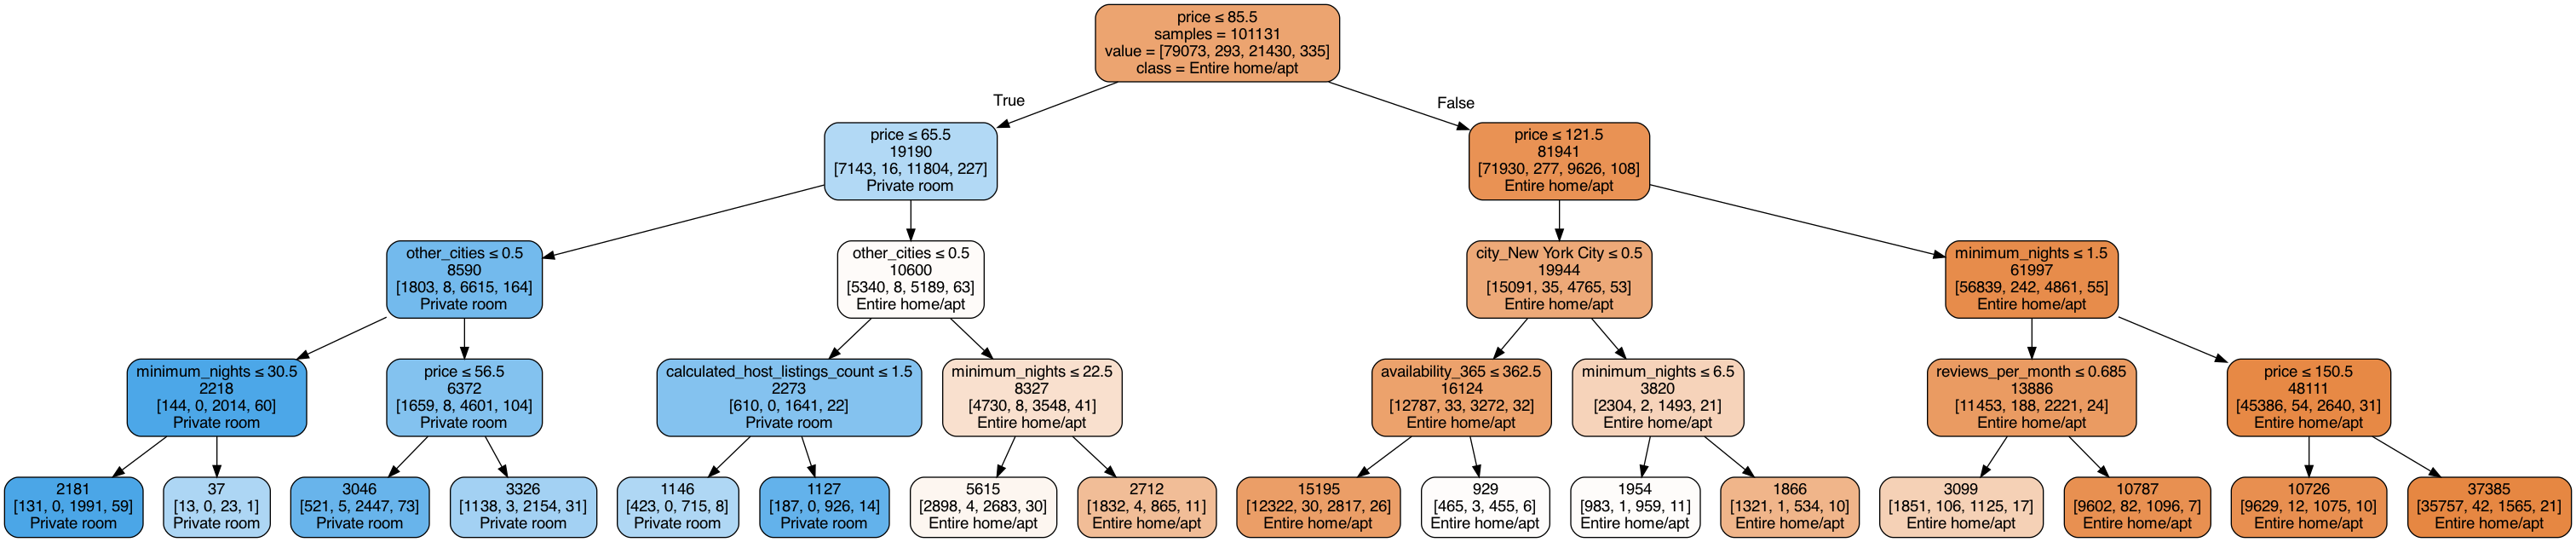

In [80]:
#using only important variables
X = airbnb_df[['price', 'minimum_nights', 'calculated_host_listings_count', 'number_of_reviews',
       'reviews_per_month', 'availability_365', 'city_New York City', 'other_cities']]
y = airbnb_df['room_type']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier(random_state=1, max_depth=4, min_impurity_decrease = 0, min_samples_split= 2000)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns, class_names=fullClassTree.classes_)

In [81]:
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8391)

       Prediction
Actual     0     1     2     3
     0 51001     0  1570     0
     1   214     0    12     0
     2  8808     0  5571     0
     3   101     0   144     0


In [82]:
#random forest
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)


RandomForestClassifier(n_estimators=500, random_state=1)

In [83]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.8695)

       Prediction
Actual     0     1     2     3
     0 49961     3  2601     6
     1   124    41    61     0
     2  5780     3  8590     6
     3    71     0   146    28


In [84]:
#grid search
param_grid = {
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [2000, 3000, 5000, 7000], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)  
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)



Initial score:  0.8474552438543974
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 2000}


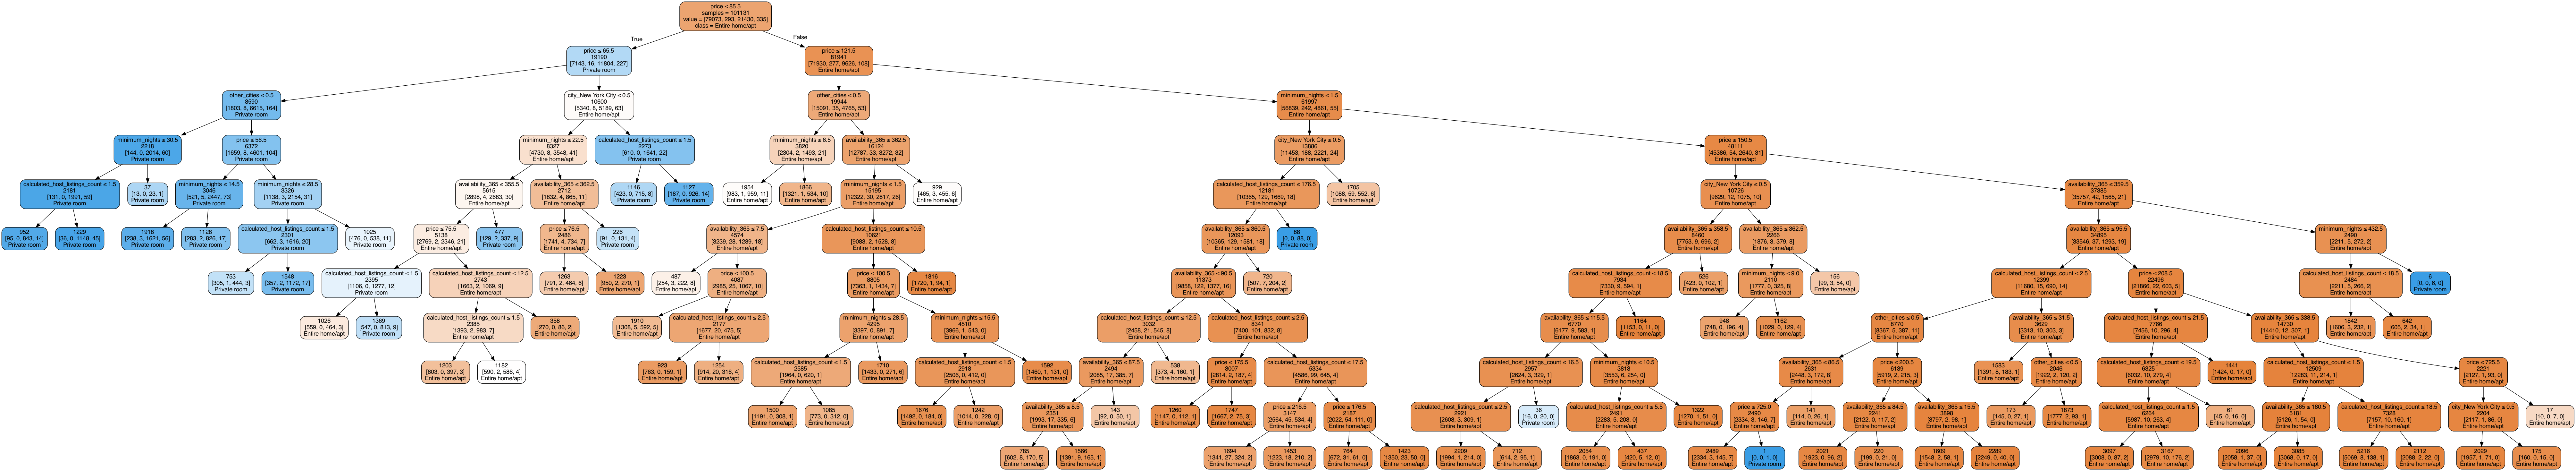

In [85]:
#using only important variables and grid search estimates
X = airbnb_df[['price', 'minimum_nights', 'calculated_host_listings_count',
       'availability_365', 'city_New York City', 'other_cities']]
y = airbnb_df['room_type']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier(random_state=1, max_depth=10, min_impurity_decrease = 0, min_samples_split= 2000)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns, class_names=fullClassTree.classes_)

In [86]:
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8449)

       Prediction
Actual     0     1     2     3
     0 50453     0  2118     0
     1   211     0    15     0
     2  7868     0  6511     0
     3    95     0   150     0


In [87]:
#boosted trees
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.8551)

       Prediction
Actual     0     1     2     3
     0 50116     5  2450     0
     1   201     4    21     0
     2  6858     1  7520     0
     3    79     0   154    12


## Model 3: Clustering to uncover different patterns

In [88]:
#Load the data
airbnb_df = pd.read_csv('airbnb.csv')
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2/19/23,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,8/6/17,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,10/27/22,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,6/28/19,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,110,1,770,2/25/23,4.65,2,159,34,San Francisco


In [89]:
#drop missing columns 
airbnb_df = airbnb_df.drop(columns=['id','neighbourhood_group', 'last_review', 'reviews_per_month'], axis=1)

In [90]:
# Removing Outliers
lower_bound = .05
upper_bound = .97
new_df = airbnb_df[airbnb_df['price'].between(airbnb_df['price'].quantile(lower_bound), airbnb_df['price'].quantile(upper_bound))]

## elbow chart 

In [91]:
cluster_df = pd.get_dummies(airbnb_df['room_type'], prefix='room_type', drop_first=False)
cluster_df = pd.concat([airbnb_df[['city','price','minimum_nights','number_of_reviews',
                                   'calculated_host_listings_count','availability_365',
                                   'number_of_reviews_ltm']], cluster_df], axis=1)

In [92]:
grouped_data = cluster_df.groupby(['city']).agg({
    'room_type_Entire home/apt': 'sum',
    'room_type_Hotel room': 'sum',
    'room_type_Private room': 'sum',
    'room_type_Shared room': 'sum',
    'price': 'mean',
    'minimum_nights': 'mean',
    'number_of_reviews': 'mean',
    'calculated_host_listings_count': 'mean',
    'availability_365': 'mean',
    'number_of_reviews_ltm': 'mean'
}).reset_index()

grouped_data.set_index('city', inplace=True)
# Normalize the data columns
grouped_data = (grouped_data - grouped_data.mean()) / grouped_data.std()


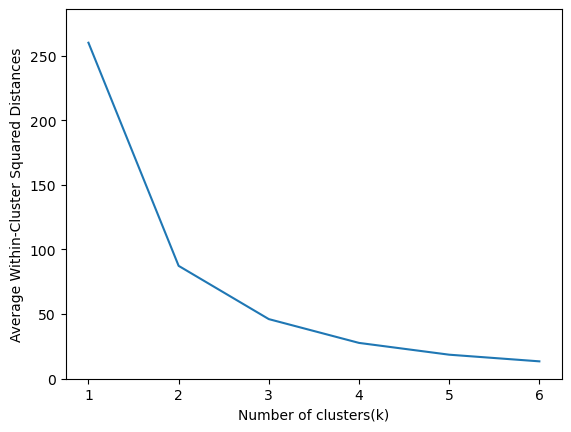

In [93]:
#just need to change this alone utilities_df_norm
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(grouped_data)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [94]:
grouped_data.head()

,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
city,,,,,,,,,,
Asheville,-0.503258,-0.339295,-0.470286,-0.469015,-0.827066,-1.062189,2.202622,-0.770443,1.023007,2.451071
Austin,0.797290,-0.475517,0.052513,0.149896,0.937677,-0.734604,-0.812289,-0.568757,-1.837220,-0.758505
Boston,-0.534895,-0.254156,-0.235697,-0.414405,-0.623354,2.589847,-0.486423,2.190574,0.753753,-0.437929
Broward County,1.157035,0.324790,0.045553,0.137760,0.960217,-1.037365,-1.196350,-0.227448,1.892661,-0.680853
Cambridge,-0.809463,-0.611740,-0.464615,-0.481150,-0.687272,1.869913,-0.022897,0.428370,-0.977762,-0.455410


In [95]:
grouped_data.shape

(27, 10)

In [96]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(grouped_data)
grouped_data['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=grouped_data.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  Asheville, Columbus, Nashville, New Orleans, Pacific Grove, Portland, Salem, San Mateo County, Santa Cruz County, Seattle
1 :  Los Angeles, New York City
2 :  Boston, Cambridge, Chicago, Denver, Jersey City, Oakland, San Francisco, Santa Clara County, Washington D.C.
3 :  Austin, Broward County, Clark County, Rhode Island, San Diego, Twin Cities MSA


In [97]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['room_type_Entire home/apt','room_type_Hotel room', 'room_type_Private room',
                                                           'room_type_Shared room', 'price', 'minimum_nights',
                                                           'number_of_reviews', 'calculated_host_listings_count',
                                                           'availability_365','number_of_reviews_ltm'])

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                     -0.446                -0.341                  -0.425   
1                      2.952                 1.772                   3.304   
2                     -0.426                -0.296                  -0.242   
3                      0.397                 0.421                  -0.030   

   room_type_Shared room  price  minimum_nights  number_of_reviews  \
0                 -0.416 -0.314          -0.540              0.955   
1                  3.351  0.046           0.815             -1.130   
2                 -0.194 -0.417           0.965             -0.386   
3                 -0.132  1.134          -0.819             -0.635   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  
0                          -0.446             0.362                  0.973  
1                           0.955            -0.857                 -1.382  
2                          

In [98]:
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals. 
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

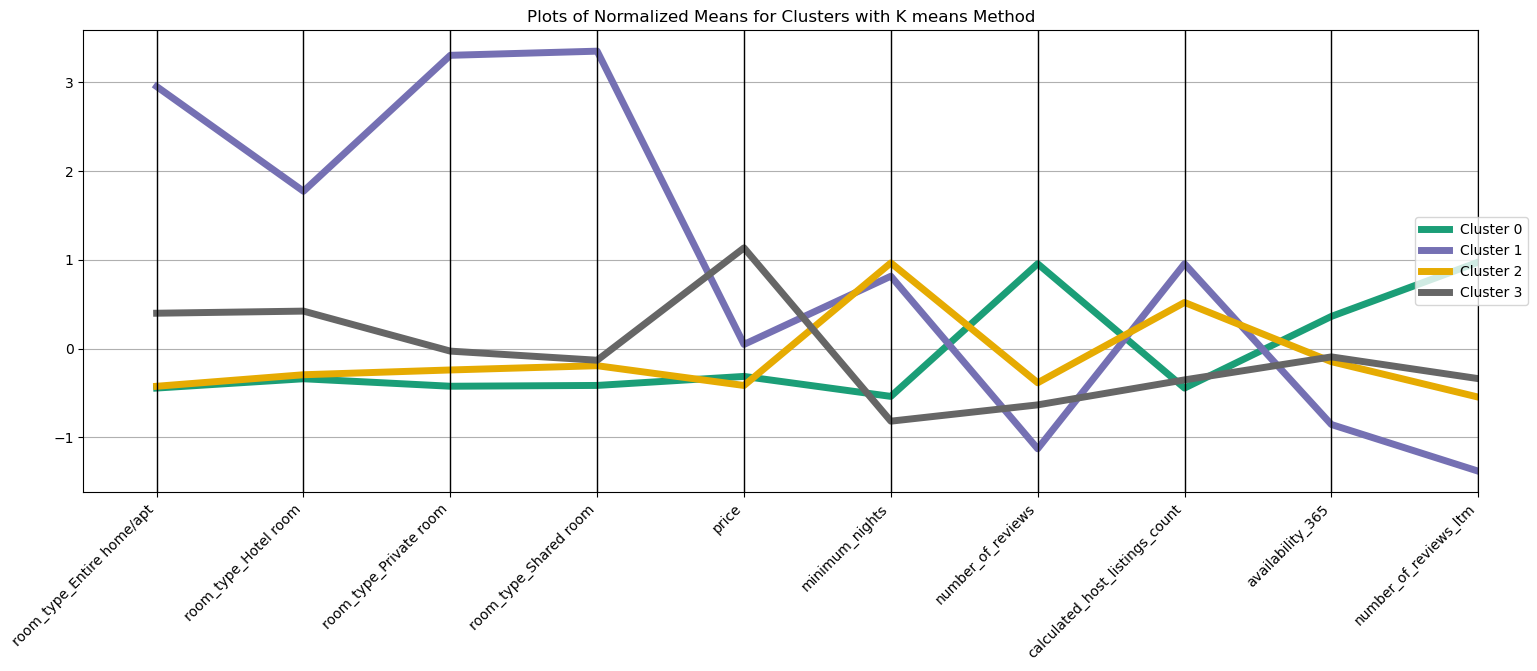

In [99]:
# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18,6))
#fig = plt.gcf()
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster', 
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,9)
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()

In [100]:
#cluster on the map
merged_data = pd.merge(grouped_data, airbnb_df[['city', 'latitude', 'longitude']], on='city', how='left')
merged_data = merged_data.drop_duplicates(subset=['city', 'cluster'])

# Define a color mapping dictionary for each cluster
cluster_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'orange',
    # Add more colors for additional clusters as needed
}

# Create a folium map centered around the average latitude and longitude of the data
map_center = [merged_data['latitude'].mean(), merged_data['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add circle markers for each city with cluster information
for index, row in merged_data.iterrows():
    cluster_color = cluster_colors.get(row['cluster'], 'black')  # Default to black if the cluster is not in the dictionary
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7,
        popup=f"City: {row['city']} - Cluster: {row['cluster']}"
    ).add_to(mymap)

# Display the map
display(mymap)
